# Introducción

## Librerías

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


import ollama
from tqdm import tqdm
import re

In [70]:
# Configuración general de estilo para matplotlib
plt.rcParams.update({
    'font.size': 18,  # Tamaño base de fuente
    'axes.titlesize': 18,  # Tamaño de títulos de subplots
    'axes.labelsize': 18,  # Tamaño de etiquetas de ejes
    'xtick.labelsize': 18,  # Tamaño de etiquetas del eje x
    'ytick.labelsize': 18,  # Tamaño de etiquetas del eje y
    'figure.titlesize': 24  # Tamaño del título principal
})

In [48]:
cols_to_use = ['question', 'category']

qrels_2020 = pd.read_csv("datasets/qrels/qrels_2020.csv", usecols=cols_to_use)
qrels_2021 = pd.read_csv("datasets/qrels/qrels_2021.csv", usecols=cols_to_use)
qrels_2022 = pd.read_csv("datasets/qrels/qrels_2022.csv", usecols=cols_to_use)

In [49]:
qrels_2020.head()

,category,question
0,harmful,Can vitamin D cure COVID-19?
1,harmful,Can vitamin D cure COVID-19?
2,harmful,Can vitamin D cure COVID-19?
3,harmful,Can vitamin D cure COVID-19?
4,harmful,Can vitamin D cure COVID-19?


In [50]:
# Agrupar por pregunta y contar cuántas veces aparece como harmful y helpful
qrels_2020 = qrels_2020.groupby(["question", "category"]).size().unstack(fill_value=0).reset_index()
qrels_2021 = qrels_2021.groupby(["question", "category"]).size().unstack(fill_value=0).reset_index()
qrels_2022 = qrels_2022.groupby(["question", "category"]).size().unstack(fill_value=0).reset_index()

qrels_2020.head()

category,question,harmful,helpful
0,Can 5G antennas cause COVID-19?,35,123
1,Can ACE and ARBs worsen COVID-19?,6,167
2,Can BCG vaccine prevent COVID-19?,0,151
3,Can Cannabis help COVID-19?,0,90
4,Can Echinacea prevent COVID-19?,53,56


In [15]:
print(qrels_2020["question"].nunique())
print(qrels_2021["question"].nunique())
print(qrels_2022["question"].nunique())

45
35
45


# Ollama LLM mistral model

## Prueba

In [16]:
respuesta = ollama.chat(
    model='mistral',
    messages=[
        {"role": "user", "content": "¿Cuál es la capital de Francia?"}
    ]
)

print(respuesta['message']['content'])

 La capital de Francia es París.


In [17]:
# Función para extraer y redondear el primer número del texto
def extract_score(text):
    try:
        match = re.search(r"\d+(\.\d+)?", text)  # Buscar primer número
        if match:
            value = float(match.group(0))
            rounded = round(value)
            if 1 <= rounded <= 5:
                return rounded
    except:
        pass
    return None

## Prompt 1

In [58]:
prompt1 = """You are an expert in information retrieval and search engine bias. Given a query, you must determine its level of controversy within the context of health-related information retrieval.
Consider factors such as ambiguity, polarization in search results, potential misinformation and conflicting information.
Think step by step and provide a score on an integer scale of 1 (not controversial) to 5 (highly controversial) for the query: {query}
Your answer should be a single integer representing the total score. Do not include any other information."""

"Eres un experto en recuperación de información y sesgo en motores de búsqueda. 
Dada una consulta, debes determinar su nivel de controversia dentro del contexto de la recuperación de información relacionada con la salud.
Considera factores como la ambigüedad, la polarización en los resultados de búsqueda, la posible desinformación y la información contradictoria.
Piensa paso a paso y proporciona una puntuación en una escala entera del 1 (nada controvertida) al 5 (altamente controvertida) para la consulta: {query}
Tu respuesta debe ser un único número entero que represente la puntuación total. No incluyas ninguna otra información."

In [40]:
# Subconjunto de prueba
sample_questions = qrels_2020["question"].unique()[:5]

for q in sample_questions:
    prompt = prompt1.format(query=q)
    response = ollama.chat(
        model="mistral",
        messages=[{"role": "user", "content": prompt}]
    )
    print(f"Pregunta: {q}")
    print(f"Puntuación de controversia: {response['message']['content']}")
    print("—" * 50)

Pregunta: Can 5G antennas cause COVID-19?
Puntuación de controversia: 4
——————————————————————————————————————————————————
Pregunta: Can ACE and ARBs worsen COVID-19?
Puntuación de controversia: 3.5

Explanation: The query "Can ACE and ARBs worsen COVID-19?" is moderately to highly controversial within the context of health-related information retrieval due to conflicting evidence, polarization in search results, and potential misinformation related to the impact of ACE inhibitors (ACE) and Angiotensin Receptor Blockers (ARBs) on SARS-CoV-2 (the virus causing COVID-19). There is ongoing research into this topic, and the available evidence is not conclusive. Misinformation can also complicate matters as it may present inaccurate or biased information that further polarizes search results and potentially misleads users.
——————————————————————————————————————————————————
Pregunta: Can BCG vaccine prevent COVID-19?
Puntuación de controversia: 4

The query "Can BCG vaccine prevent COVID-19?

### 2020

In [12]:
# Lista para guardar puntuaciones
controversy_scores = []

# Aplicar a cada pregunta
for question in tqdm(qrels_2020["question"], desc="Analizando controversia..."):
    prompt = prompt1.format(query=question)
    try:
        response = ollama.chat(
            model="mistral",
            messages=[{"role": "user", "content": prompt}]
        )
        content = response["message"]["content"].strip()
        score = extract_score(content)
    except Exception as e:
        print(f"Error con query: {question[:50]}... → {e}")
        score = None

    controversy_scores.append(score)

# Añadir columna al DataFrame
qrels_2020_prompt1 = qrels_2020.copy()
qrels_2020_prompt1["controversy_score"] = controversy_scores

Analizando controversia...: 100%|██████████| 45/45 [05:13<00:00,  6.97s/it]


In [13]:
qrels_2020_prompt1

category,question,harmful,helpful,controversy_score
0,Can 5G antennas cause COVID-19?,35,123,4
1,Can ACE and ARBs worsen COVID-19?,6,167,4
2,Can BCG vaccine prevent COVID-19?,0,151,4
3,Can Cannabis help COVID-19?,0,90,4
4,Can Echinacea prevent COVID-19?,53,56,3
5,Can Ginger cure COVID-19?,30,103,4
6,Can Hib vaccine prevent COVID-19?,3,149,4
7,Can Homemade Vodka Sanitizer prevent COVID-19?,13,273,5
8,Can Hydroxychloroquine worsen COVID-19?,0,183,4
9,Can IVIG cure COVID-19?,7,6,4


### 2021

In [14]:
# Lista para guardar puntuaciones
controversy_scores = []

# Aplicar a cada pregunta
for question in tqdm(qrels_2021["question"], desc="Analizando controversia..."):
    prompt = prompt1.format(query=question)
    try:
        response = ollama.chat(
            model="mistral",
            messages=[{"role": "user", "content": prompt}]
        )
        content = response["message"]["content"].strip()
        score = extract_score(content)
    except Exception as e:
        print(f"Error con query: {question[:50]}... → {e}")
        score = None

    controversy_scores.append(score)

# Añadir columna al DataFrame
qrels_2021_prompt1 = qrels_2021.copy()
qrels_2021_prompt1["controversy_score"] = controversy_scores

Analizando controversia...: 100%|██████████| 35/35 [01:48<00:00,  3.10s/it]


In [33]:
qrels_2021_prompt1

category,question,harmful,helpful,controversy_score
0,Can I remove a tick by covering it with Vaseline?,21,167,3
1,Can applying vitamin E cream remove skin scars?,26,315,3
2,Can aromatherapy massage help manage rheumatoi...,0,100,3
3,Can copper bracelets reduce the pain of arthri...,74,53,3
4,Can dupixent treat eczema?,5,176,3
5,Can eating dates help manage iron deficiency a...,3,187,3
6,Can evening primrose oil help treat eczema?,116,22,3
7,Can fermented milk help mitigate high blood pr...,8,156,3
8,Can folic acid help improve cognition and trea...,139,52,4
9,Can fungal creams treat athlete's foot?,1,251,2


### 2022

In [34]:
# Lista para guardar puntuaciones
controversy_scores = []

# Aplicar a cada pregunta
for question in tqdm(qrels_2022["question"], desc="Analizando controversia..."):
    prompt = prompt1.format(query=question)
    try:
        response = ollama.chat(
            model="mistral",
            messages=[{"role": "user", "content": prompt}]
        )
        content = response["message"]["content"].strip()
        score = extract_score(content)
    except Exception as e:
        print(f"Error con query: {question[:50]}... → {e}")
        score = None

    controversy_scores.append(score)

# Añadir columna al DataFrame
qrels_2022_prompt1 = qrels_2022.copy()
qrels_2022_prompt1["controversy_score"] = controversy_scores

Analizando controversia...: 100%|██████████| 45/45 [01:50<00:00,  2.46s/it]


In [35]:
qrels_2022_prompt1

category,question,harmful,helpful,controversy_score
0,Are carrots good for your eyes?,6,126,2
1,Are sit ups bad for you?,0,44,3
2,Are skin tags contagious?,0,70,2
3,Are squats bad for knees?,7,176,3
4,Are there health benefits to drinking your own...,29,57,5
5,Are vaccines linked to autism?,51,183,4
6,Can HIV be transmitted through sweat?,1,190,3
7,Can a cold sore cause genital herpes?,0,143,3
8,Can a woman get pregnant while breastfeeding?,3,132,3
9,Can an MRI harm my baby?,2,97,3


### Guardar dataset con puntuación de controversia con prompt1

In [36]:
qrels_2020_prompt1.to_csv("datasets/llm/prompt1/qrels_2020_llm_prompt1.csv", index=False)
qrels_2021_prompt1.to_csv("datasets/llm/prompt1/qrels_2021_llm_prompt1.csv", index=False)
qrels_2022_prompt1.to_csv("datasets/llm/prompt1/qrels_2022_llm_prompt1.csv", index=False)

## Prompt 2

In [37]:
prompt2 = """
You are an expert in health-related information retrieval. Given a query, you must assess its potential for generating controversy in search results.

Controversy may arise from ambiguity, presence of misinformation, or conflicting viewpoints among credible sources. Rate the query on a scale from 1 to 5, where:

1 = Not controversial (clear, factual, no known dispute)
2 = Slightly controversial (minor disagreement or uncommon claim)
3 = Moderately controversial (some credible disagreement or frequent misconception)
4 = Very controversial (common misinformation or conflicting sources)
5 = Highly controversial (widely debated, strongly polarized, or known for misinformation)

Just respond with a single number (1–5). Do not explain your answer.

Query: {query}
"""

### 2020

In [38]:
# Lista para guardar puntuaciones
controversy_scores = []

# Aplicar a cada pregunta
for question in tqdm(qrels_2020["question"], desc="Analizando controversia..."):
    prompt = prompt2.format(query=question)
    try:
        response = ollama.chat(
            model="mistral",
            messages=[{"role": "user", "content": prompt}]
        )
        content = response["message"]["content"].strip()
        score = extract_score(content)
    except Exception as e:
        print(f"Error con query: {question[:50]}... → {e}")
        score = None

    controversy_scores.append(score)

# Añadir columna al DataFrame
qrels_2020_prompt2 = qrels_2020.copy()
qrels_2020_prompt2["controversy_score"] = controversy_scores

Analizando controversia...: 100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


In [39]:
qrels_2020_prompt2

category,question,harmful,helpful,controversy_score
0,Can 5G antennas cause COVID-19?,35,123,5
1,Can ACE and ARBs worsen COVID-19?,6,167,3
2,Can BCG vaccine prevent COVID-19?,0,151,3
3,Can Cannabis help COVID-19?,0,90,4
4,Can Echinacea prevent COVID-19?,53,56,3
5,Can Ginger cure COVID-19?,30,103,4
6,Can Hib vaccine prevent COVID-19?,3,149,3
7,Can Homemade Vodka Sanitizer prevent COVID-19?,13,273,5
8,Can Hydroxychloroquine worsen COVID-19?,0,183,3
9,Can IVIG cure COVID-19?,7,6,4


### 2021

In [40]:
# Lista para guardar puntuaciones
controversy_scores = []

# Aplicar a cada pregunta
for question in tqdm(qrels_2021["question"], desc="Analizando controversia..."):
    prompt = prompt2.format(query=question)
    try:
        response = ollama.chat(
            model="mistral",
            messages=[{"role": "user", "content": prompt}]
        )
        content = response["message"]["content"].strip()
        score = extract_score(content)
    except Exception as e:
        print(f"Error con query: {question[:50]}... → {e}")
        score = None

    controversy_scores.append(score)

# Añadir columna al DataFrame
qrels_2021_prompt2 = qrels_2021.copy()
qrels_2021_prompt2["controversy_score"] = controversy_scores

Analizando controversia...: 100%|██████████| 35/35 [00:24<00:00,  1.45it/s]


In [41]:
qrels_2021_prompt2

category,question,harmful,helpful,controversy_score
0,Can I remove a tick by covering it with Vaseline?,21,167,3
1,Can applying vitamin E cream remove skin scars?,26,315,3
2,Can aromatherapy massage help manage rheumatoi...,0,100,3
3,Can copper bracelets reduce the pain of arthri...,74,53,3
4,Can dupixent treat eczema?,5,176,1
5,Can eating dates help manage iron deficiency a...,3,187,3
6,Can evening primrose oil help treat eczema?,116,22,3
7,Can fermented milk help mitigate high blood pr...,8,156,3
8,Can folic acid help improve cognition and trea...,139,52,3
9,Can fungal creams treat athlete's foot?,1,251,1


### 2022

In [42]:
# Lista para guardar puntuaciones
controversy_scores = []

# Aplicar a cada pregunta
for question in tqdm(qrels_2022["question"], desc="Analizando controversia..."):
    prompt = prompt2.format(query=question)
    try:
        response = ollama.chat(
            model="mistral",
            messages=[{"role": "user", "content": prompt}]
        )
        content = response["message"]["content"].strip()
        score = extract_score(content)
    except Exception as e:
        print(f"Error con query: {question[:50]}... → {e}")
        score = None

    controversy_scores.append(score)

# Añadir columna al DataFrame
qrels_2022_prompt2 = qrels_2022.copy()
qrels_2022_prompt2["controversy_score"] = controversy_scores

Analizando controversia...: 100%|██████████| 45/45 [00:26<00:00,  1.73it/s]


In [43]:
qrels_2022_prompt2

category,question,harmful,helpful,controversy_score
0,Are carrots good for your eyes?,6,126,1
1,Are sit ups bad for you?,0,44,3
2,Are skin tags contagious?,0,70,2
3,Are squats bad for knees?,7,176,3
4,Are there health benefits to drinking your own...,29,57,5
5,Are vaccines linked to autism?,51,183,4
6,Can HIV be transmitted through sweat?,1,190,3
7,Can a cold sore cause genital herpes?,0,143,3
8,Can a woman get pregnant while breastfeeding?,3,132,3
9,Can an MRI harm my baby?,2,97,3


### Guardar dataset con puntuación de controversia con prompt2

In [44]:
qrels_2020_prompt2.to_csv("datasets/llm/prompt2/qrels_2020_llm_prompt2.csv", index=False)
qrels_2021_prompt2.to_csv("datasets/llm/prompt2/qrels_2021_llm_prompt2.csv", index=False)
qrels_2022_prompt2.to_csv("datasets/llm/prompt2/qrels_2022_llm_prompt2.csv", index=False)

## Prompt 3

In [18]:
prompt3 = """You are an expert in health-related search engine results and misinformation detection.

Given a health-related query, assess its risk of returning harmful results (containing misinformation, pseudoscience, or misleading health claims) and/or suppressing helpful results (accurate, evidence-based medical information).

Controversial queries often trigger polarized opinions, recurring myths, or conflicting guidance from reliable sources. Rate the level of controversy on a scale from 1 to 5 based on the following:

1 = Clear, factual query with consistent evidence and no common misinformation
2 = Mostly factual with minimal risk of misinformation or confusion
3 = Some disagreement or presence of minor myths or fringe opinions
4 = High presence of misinformation, conflicting evidence, or misleading narratives
5 = Very high controversy with widespread misinformation or dangerous claims

Just reply with a single number (1–5). Do not explain your answer.

Query: {query}"""

In [19]:
#------------------------2020------------------------
# Lista para guardar puntuaciones
controversy_scores = []

# Aplicar a cada pregunta
for question in tqdm(qrels_2020["question"], desc="Analizando controversia..."):
    prompt = prompt3.format(query=question)
    try:
        response = ollama.chat(
            model="mistral",
            messages=[{"role": "user", "content": prompt}]
        )
        content = response["message"]["content"].strip()
        score = extract_score(content)
    except Exception as e:
        print(f"Error con query: {question[:50]}... → {e}")
        score = None

    controversy_scores.append(score)

# Añadir columna al DataFrame
qrels_2020_prompt3 = qrels_2020.copy()
qrels_2020_prompt3["controversy_score"] = controversy_scores

Analizando controversia...: 100%|██████████| 45/45 [00:29<00:00,  1.52it/s]


In [68]:
qrels_2020_prompt3

category,question,harmful,helpful,controversy_score
0,Can 5G antennas cause COVID-19?,35,123,5
1,Can ACE and ARBs worsen COVID-19?,6,167,4
2,Can BCG vaccine prevent COVID-19?,0,151,4
3,Can Cannabis help COVID-19?,0,90,4
4,Can Echinacea prevent COVID-19?,53,56,4
5,Can Ginger cure COVID-19?,30,103,4
6,Can Hib vaccine prevent COVID-19?,3,149,3
7,Can Homemade Vodka Sanitizer prevent COVID-19?,13,273,5
8,Can Hydroxychloroquine worsen COVID-19?,0,183,4
9,Can IVIG cure COVID-19?,7,6,4


In [20]:
#------------------------2021------------------------
# Lista para guardar puntuaciones
controversy_scores = []

# Aplicar a cada pregunta
for question in tqdm(qrels_2021["question"], desc="Analizando controversia..."):
    prompt = prompt3.format(query=question)
    try:
        response = ollama.chat(
            model="mistral",
            messages=[{"role": "user", "content": prompt}]
        )
        content = response["message"]["content"].strip()
        score = extract_score(content)
    except Exception as e:
        print(f"Error con query: {question[:50]}... → {e}")
        score = None

    controversy_scores.append(score)

# Añadir columna al DataFrame
qrels_2021_prompt3 = qrels_2021.copy()
qrels_2021_prompt3["controversy_score"] = controversy_scores

Analizando controversia...: 100%|██████████| 35/35 [00:21<00:00,  1.66it/s]


In [21]:
#------------------------2022------------------------
# Lista para guardar puntuaciones
controversy_scores = []

# Aplicar a cada pregunta
for question in tqdm(qrels_2022["question"], desc="Analizando controversia..."):
    prompt = prompt3.format(query=question)
    try:
        response = ollama.chat(
            model="mistral",
            messages=[{"role": "user", "content": prompt}]
        )
        content = response["message"]["content"].strip()
        score = extract_score(content)
    except Exception as e:
        print(f"Error con query: {question[:50]}... → {e}")
        score = None

    controversy_scores.append(score)

# Añadir columna al DataFrame
qrels_2022_prompt3 = qrels_2022.copy()
qrels_2022_prompt3["controversy_score"] = controversy_scores

Analizando controversia...: 100%|██████████| 45/45 [00:27<00:00,  1.66it/s]


### Guardar dataset con puntuación de controversia con prompt3

In [23]:
qrels_2020_prompt3.to_csv("datasets/llm/prompt3/qrels_2020_llm_prompt3.csv", index=False)
qrels_2021_prompt3.to_csv("datasets/llm/prompt3/qrels_2021_llm_prompt3.csv", index=False)
qrels_2022_prompt3.to_csv("datasets/llm/prompt3/qrels_2022_llm_prompt3.csv", index=False)

# Gráficos

## Prompt 1

### 2020

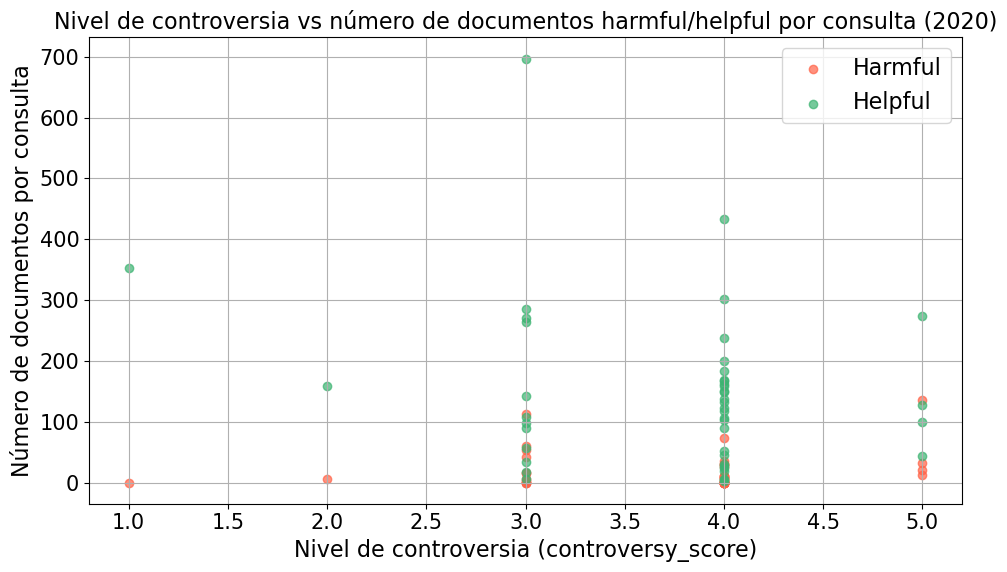

In [46]:
plt.figure(figsize=(10, 6))

# Puntos individuales por consulta
plt.scatter(qrels_2020_prompt1["controversy_score"], qrels_2020_prompt1["harmful"], color="tomato", alpha=0.7, label="Harmful")
plt.scatter(qrels_2020_prompt1["controversy_score"], qrels_2020_prompt1["helpful"], color="mediumseagreen", alpha=0.7, label="Helpful")

plt.title("Nivel de controversia vs número de documentos harmful/helpful por consulta (2020)")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos por consulta")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

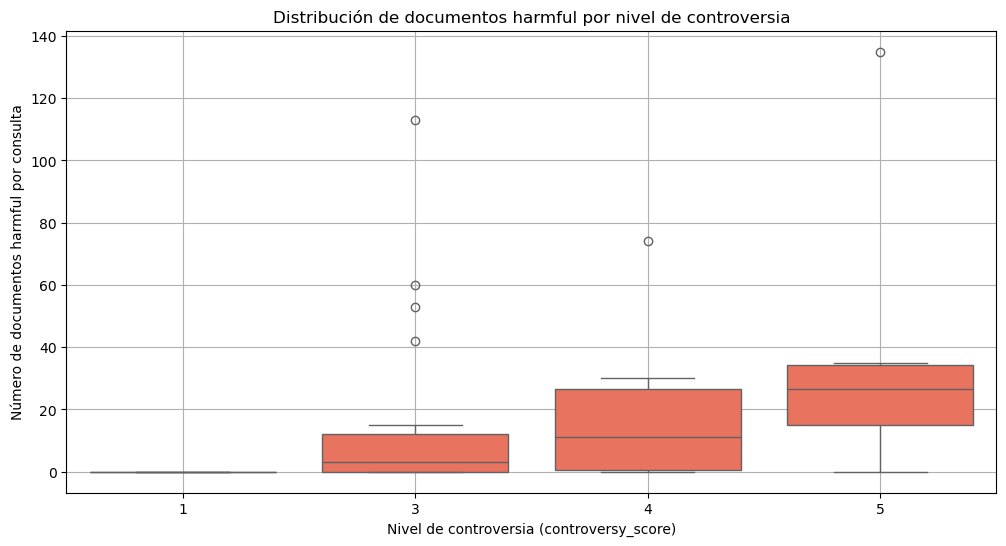

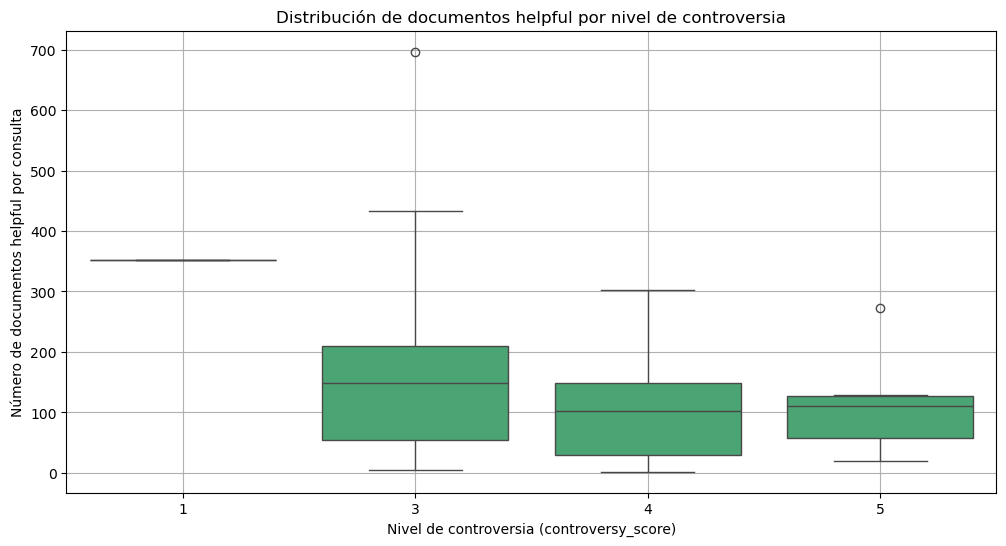

In [110]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=qrels_2020_prompt1, x="controversy_score", y="harmful", color="tomato")
plt.title("Distribución de documentos harmful por nivel de controversia")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos harmful por consulta")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=qrels_2020_prompt1, x="controversy_score", y="helpful", color="mediumseagreen")
plt.title("Distribución de documentos helpful por nivel de controversia")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos helpful por consulta")
plt.grid(True)
plt.show()

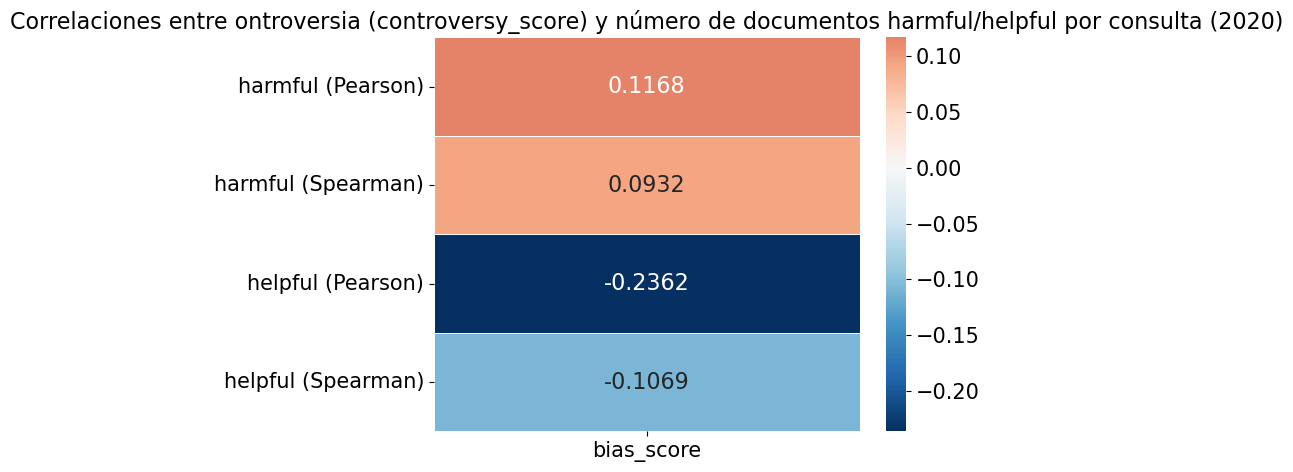

In [50]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    "bias_score": {
        "harmful (Pearson)": pearsonr(qrels_2020_prompt1["controversy_score"], qrels_2020_prompt1["harmful"])[0],
        "harmful (Spearman)": spearmanr(qrels_2020_prompt1["controversy_score"], qrels_2020_prompt1["harmful"])[0],
        "helpful (Pearson)": pearsonr(qrels_2020_prompt1["controversy_score"], qrels_2020_prompt1["helpful"])[0],
        "helpful (Spearman)": spearmanr(qrels_2020_prompt1["controversy_score"], qrels_2020_prompt1["helpful"])[0],
    }
}
correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre ontroversia (controversy_score) y número de documentos harmful/helpful por consulta (2020)")
plt.tight_layout()
plt.show()

### 2021

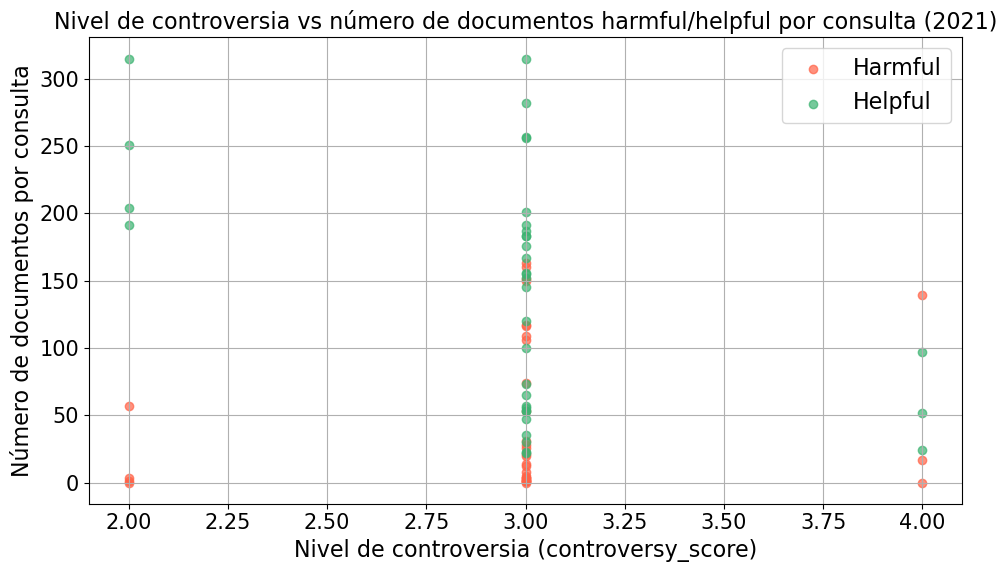

In [52]:
plt.figure(figsize=(10, 6))

# Puntos individuales por consulta
plt.scatter(qrels_2021_prompt1["controversy_score"], qrels_2021_prompt1["harmful"], color="tomato", alpha=0.7, label="Harmful")
plt.scatter(qrels_2021_prompt1["controversy_score"], qrels_2021_prompt1["helpful"], color="mediumseagreen", alpha=0.7, label="Helpful")

plt.title("Nivel de controversia vs número de documentos harmful/helpful por consulta (2021)")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos por consulta")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

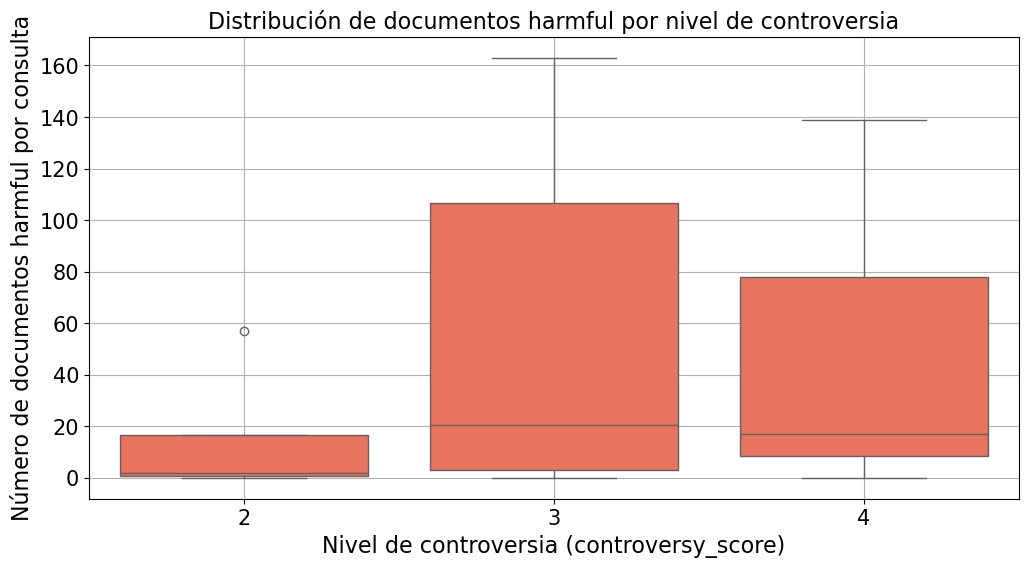

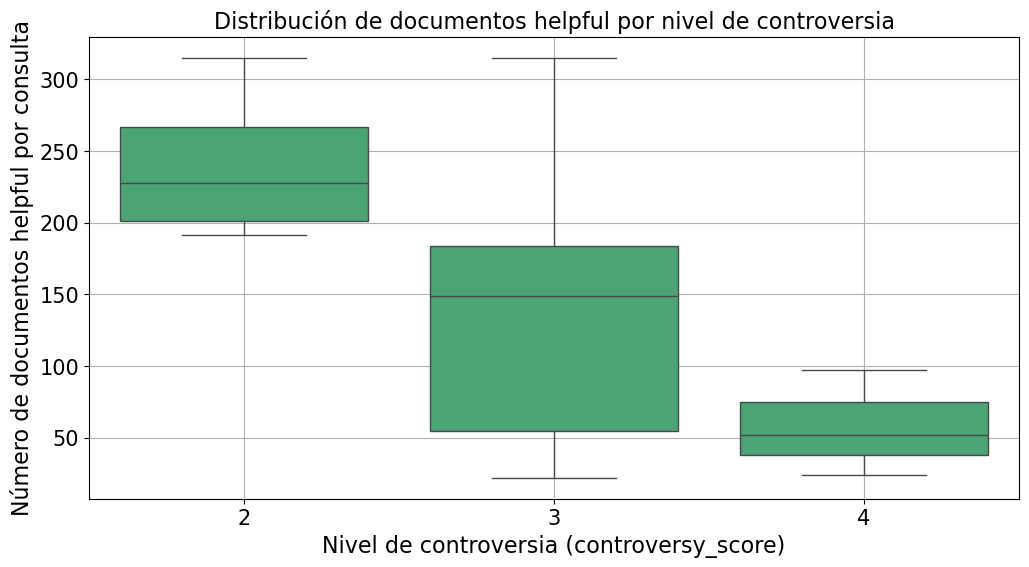

In [54]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=qrels_2021_prompt1, x="controversy_score", y="harmful", color="tomato")
plt.title("Distribución de documentos harmful por nivel de controversia")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos harmful por consulta")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=qrels_2021_prompt1, x="controversy_score", y="helpful", color="mediumseagreen")
plt.title("Distribución de documentos helpful por nivel de controversia")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos helpful por consulta")
plt.grid(True)
plt.show()

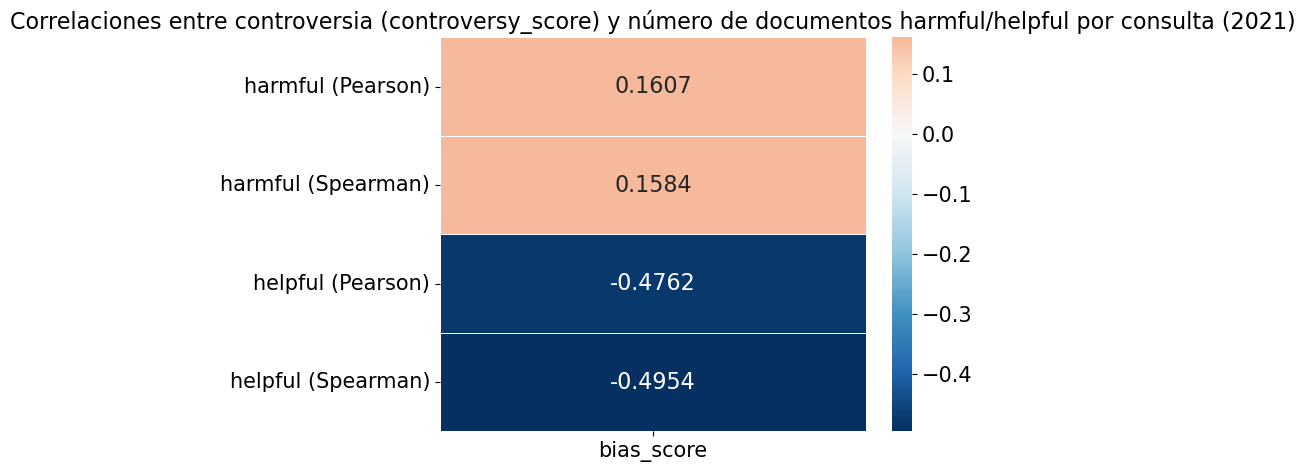

In [56]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    "bias_score": {
        "harmful (Pearson)": pearsonr(qrels_2021_prompt1["controversy_score"], qrels_2021_prompt1["harmful"])[0],
        "harmful (Spearman)": spearmanr(qrels_2021_prompt1["controversy_score"], qrels_2021_prompt1["harmful"])[0],
        "helpful (Pearson)": pearsonr(qrels_2021_prompt1["controversy_score"], qrels_2021_prompt1["helpful"])[0],
        "helpful (Spearman)": spearmanr(qrels_2021_prompt1["controversy_score"], qrels_2021_prompt1["helpful"])[0],
    }
}
correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre controversia (controversy_score) y número de documentos harmful/helpful por consulta (2021)")
plt.tight_layout()
plt.show()

### 2022

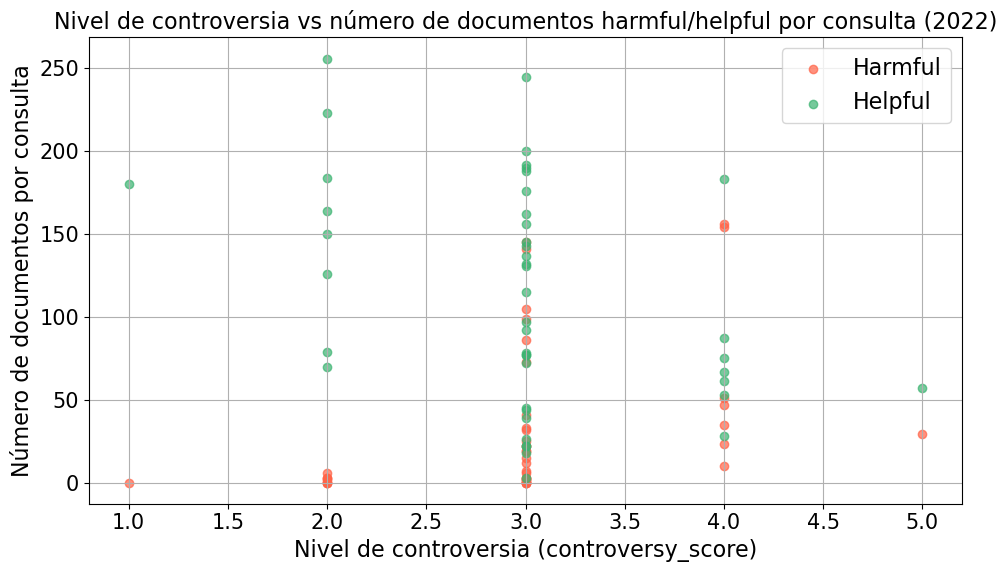

In [58]:
plt.figure(figsize=(10, 6))

# Puntos individuales por consulta
plt.scatter(qrels_2022_prompt1["controversy_score"], qrels_2022_prompt1["harmful"], color="tomato", alpha=0.7, label="Harmful")
plt.scatter(qrels_2022_prompt1["controversy_score"], qrels_2022_prompt1["helpful"], color="mediumseagreen", alpha=0.7, label="Helpful")

plt.title("Nivel de controversia vs número de documentos harmful/helpful por consulta (2022)")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos por consulta")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

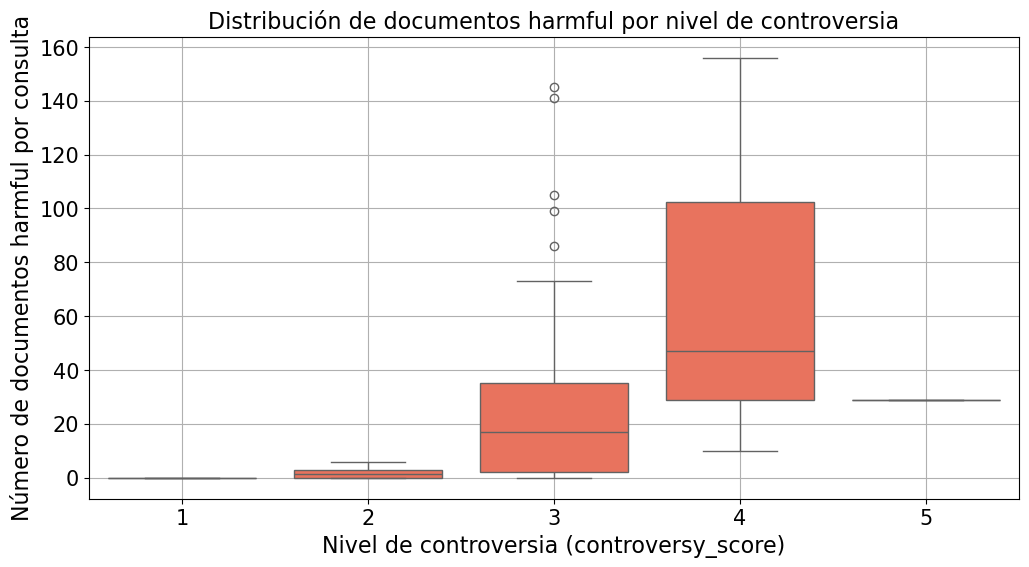

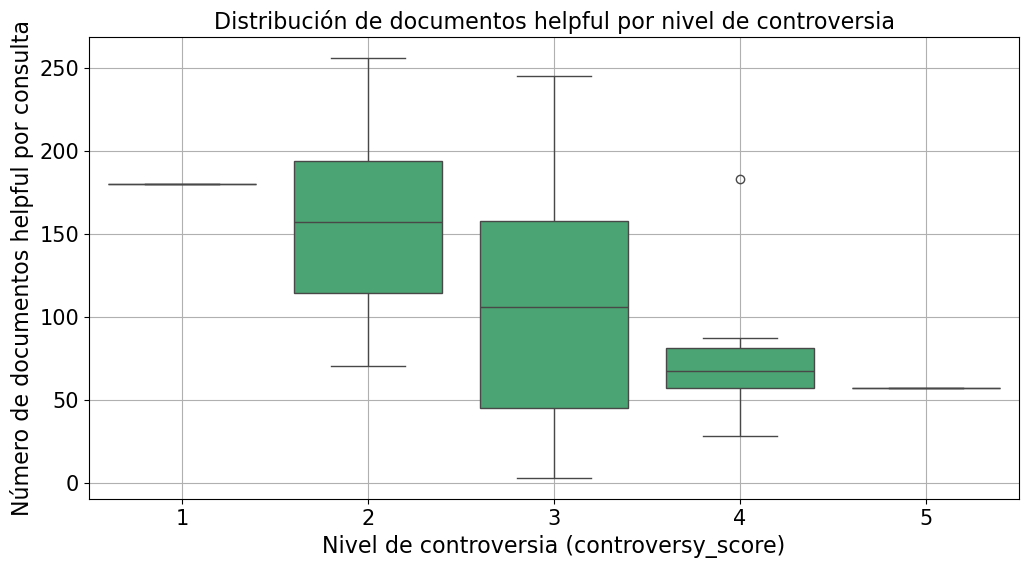

In [60]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=qrels_2022_prompt1, x="controversy_score", y="harmful", color="tomato")
plt.title("Distribución de documentos harmful por nivel de controversia")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos harmful por consulta")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=qrels_2022_prompt1, x="controversy_score", y="helpful", color="mediumseagreen")
plt.title("Distribución de documentos helpful por nivel de controversia")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos helpful por consulta")
plt.grid(True)
plt.show()

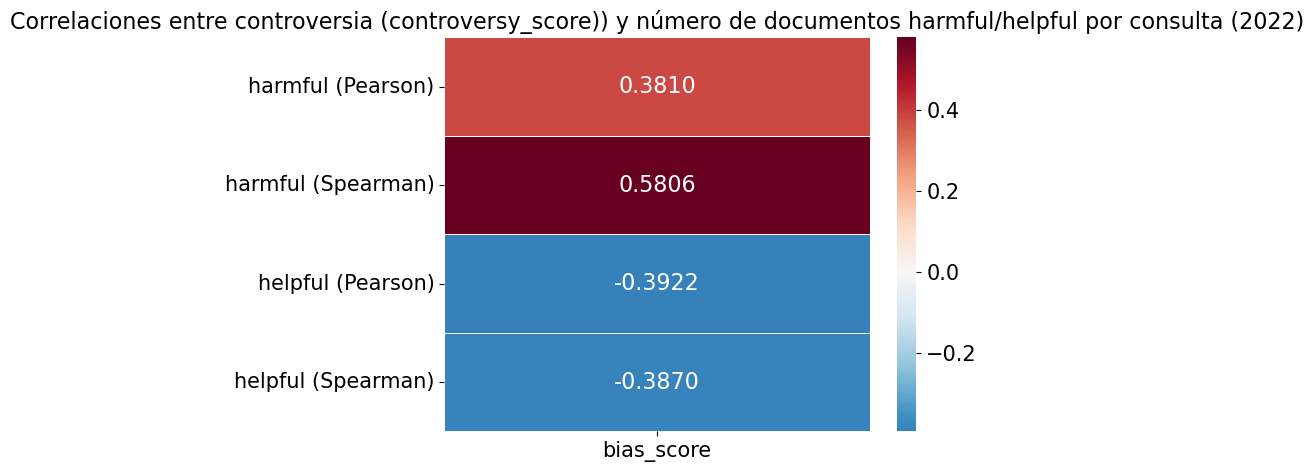

In [63]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    "bias_score": {
        "harmful (Pearson)": pearsonr(qrels_2022_prompt1["controversy_score"], qrels_2022_prompt1["harmful"])[0],
        "harmful (Spearman)": spearmanr(qrels_2022_prompt1["controversy_score"], qrels_2022_prompt1["harmful"])[0],
        "helpful (Pearson)": pearsonr(qrels_2022_prompt1["controversy_score"], qrels_2022_prompt1["helpful"])[0],
        "helpful (Spearman)": spearmanr(qrels_2022_prompt1["controversy_score"], qrels_2022_prompt1["helpful"])[0],
    }
}
correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre controversia (controversy_score)) y número de documentos harmful/helpful por consulta (2022)")
plt.tight_layout()
plt.show()

## Prompt 2

### 2020

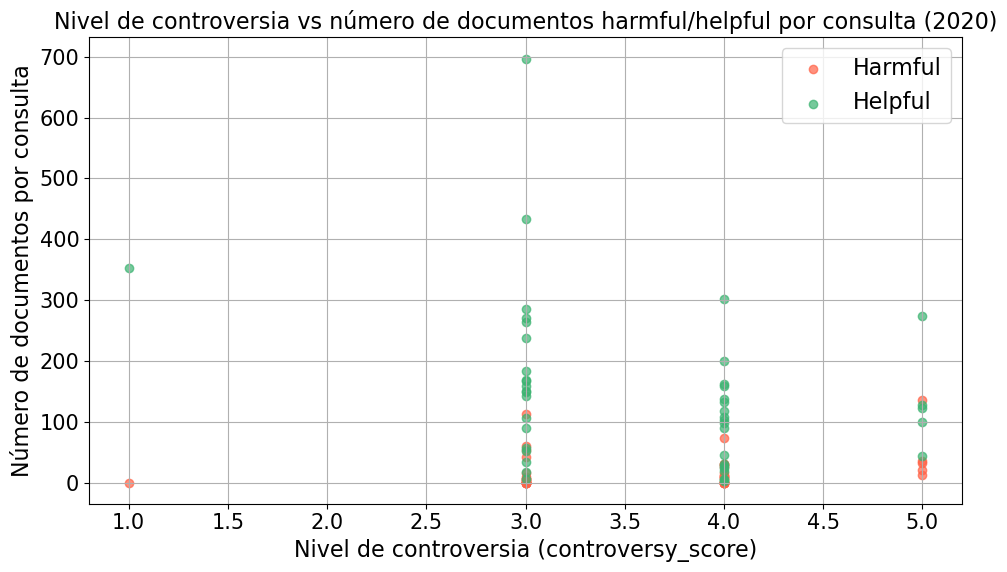

In [47]:
plt.figure(figsize=(10, 6))

# Puntos individuales por consulta
plt.scatter(qrels_2020_prompt2["controversy_score"], qrels_2020_prompt2["harmful"], color="tomato", alpha=0.7, label="Harmful")
plt.scatter(qrels_2020_prompt2["controversy_score"], qrels_2020_prompt2["helpful"], color="mediumseagreen", alpha=0.7, label="Helpful")

plt.title("Nivel de controversia vs número de documentos harmful/helpful por consulta (2020)")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos por consulta")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

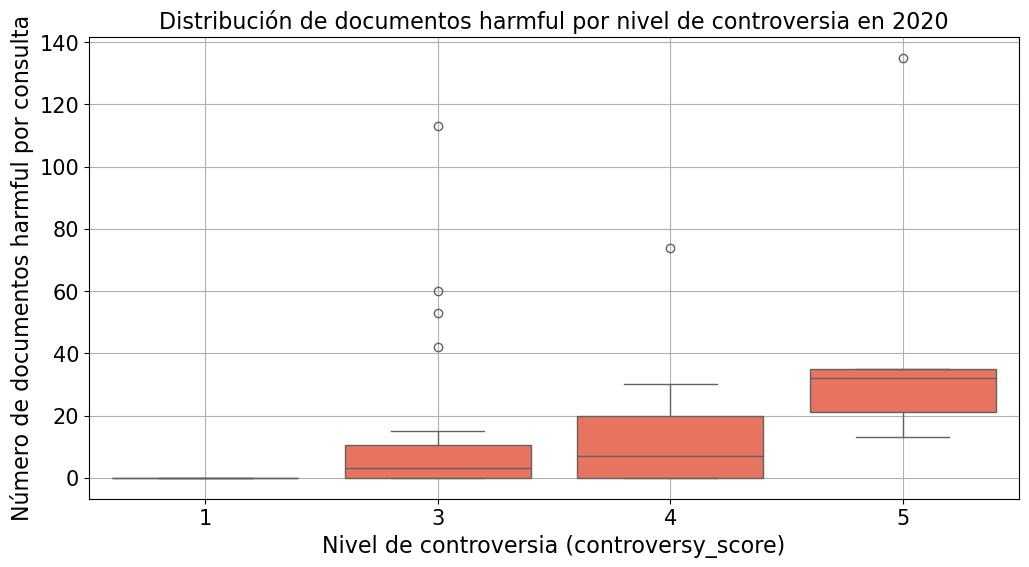

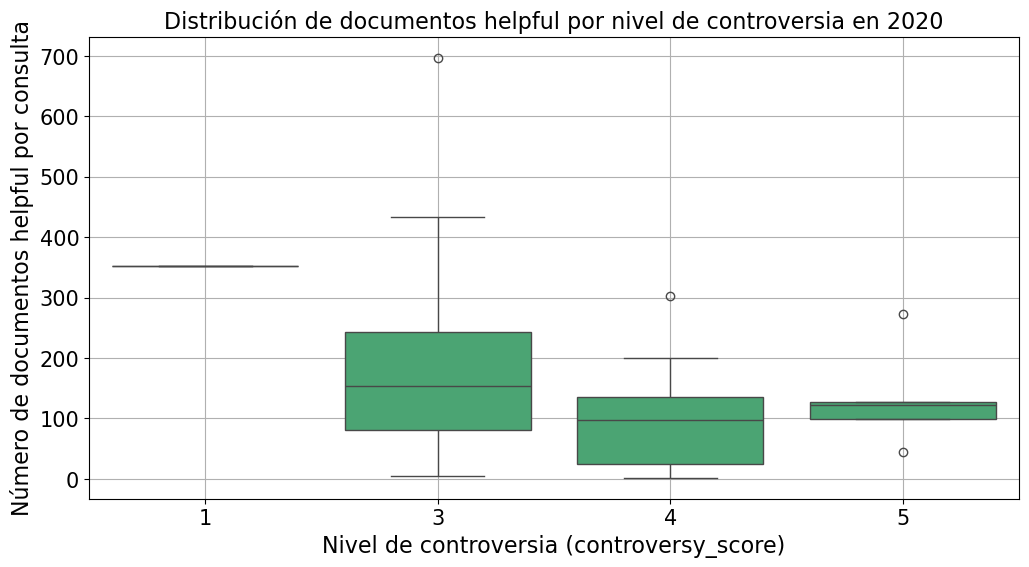

In [94]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=qrels_2020_prompt2, x="controversy_score", y="harmful", color="tomato")
plt.title("Distribución de documentos harmful por nivel de controversia en 2020")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos harmful por consulta")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=qrels_2020_prompt2, x="controversy_score", y="helpful", color="mediumseagreen")
plt.title("Distribución de documentos helpful por nivel de controversia en 2020")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos helpful por consulta")
plt.grid(True)
plt.show()

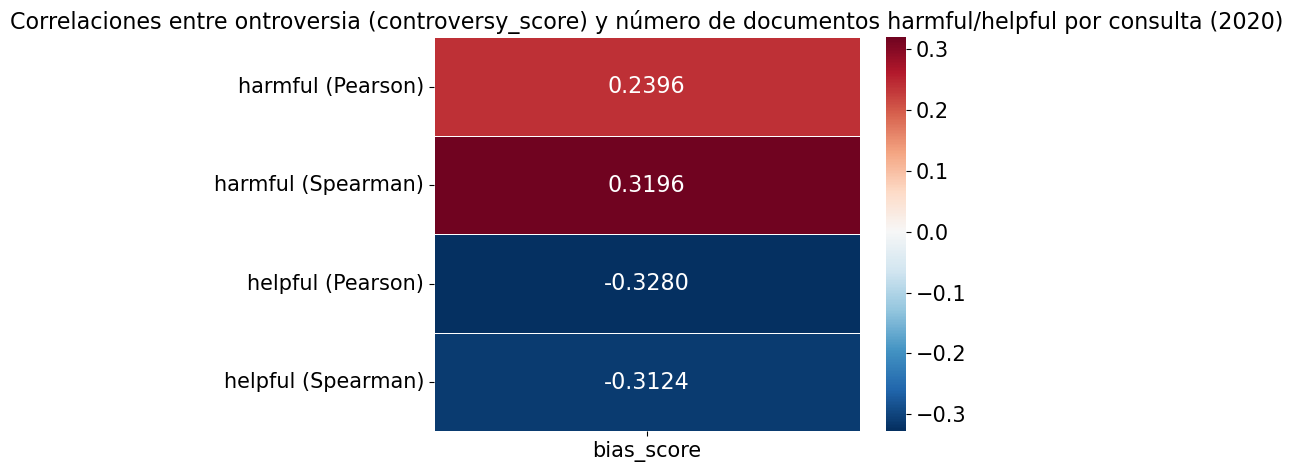

In [51]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    "bias_score": {
        "harmful (Pearson)": pearsonr(qrels_2020_prompt2["controversy_score"], qrels_2020_prompt2["harmful"])[0],
        "harmful (Spearman)": spearmanr(qrels_2020_prompt2["controversy_score"], qrels_2020_prompt2["harmful"])[0],
        "helpful (Pearson)": pearsonr(qrels_2020_prompt2["controversy_score"], qrels_2020_prompt2["helpful"])[0],
        "helpful (Spearman)": spearmanr(qrels_2020_prompt2["controversy_score"], qrels_2020_prompt2["helpful"])[0],
    }
}
correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre ontroversia (controversy_score) y número de documentos harmful/helpful por consulta (2020)")
plt.tight_layout()
plt.show()

### 2021

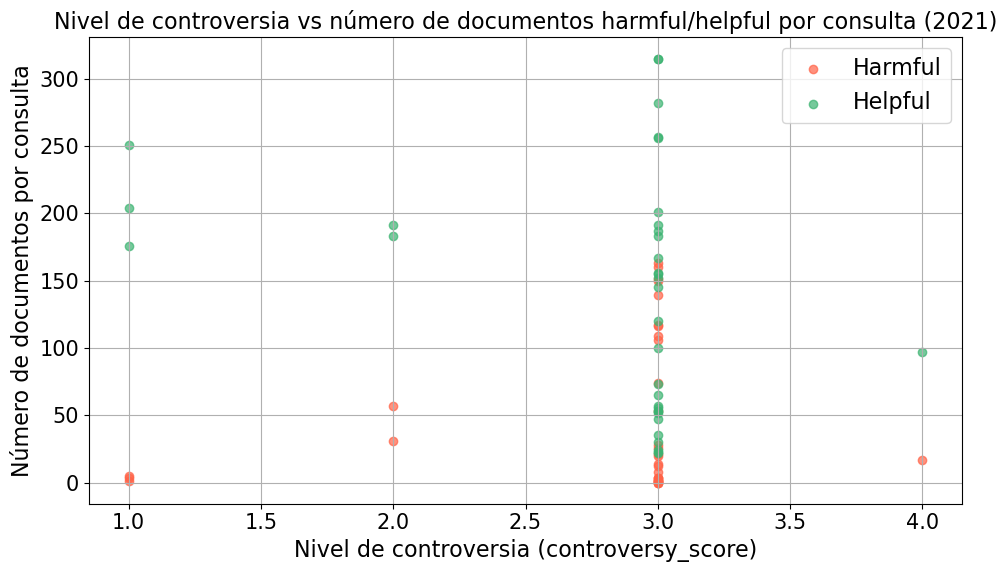

In [53]:
plt.figure(figsize=(10, 6))

# Puntos individuales por consulta
plt.scatter(qrels_2021_prompt2["controversy_score"], qrels_2021_prompt2["harmful"], color="tomato", alpha=0.7, label="Harmful")
plt.scatter(qrels_2021_prompt2["controversy_score"], qrels_2021_prompt2["helpful"], color="mediumseagreen", alpha=0.7, label="Helpful")

plt.title("Nivel de controversia vs número de documentos harmful/helpful por consulta (2021)")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos por consulta")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

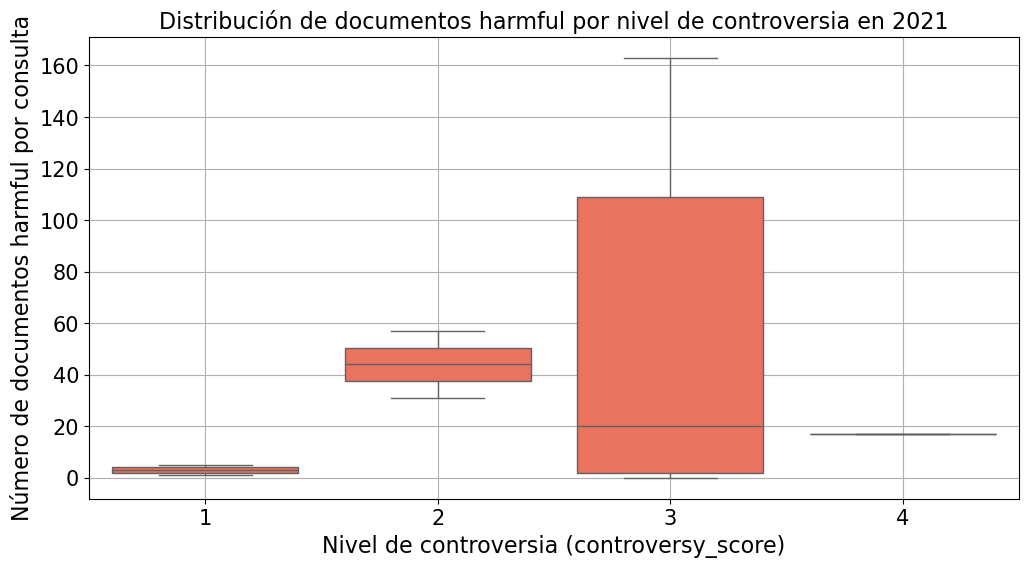

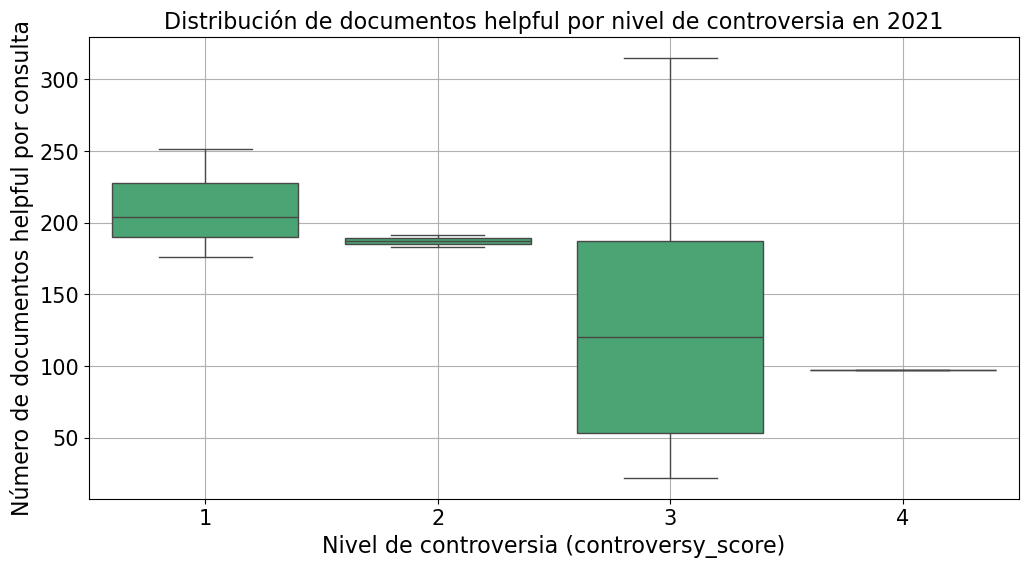

In [93]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=qrels_2021_prompt2, x="controversy_score", y="harmful", color="tomato")
plt.title("Distribución de documentos harmful por nivel de controversia en 2021")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos harmful por consulta")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=qrels_2021_prompt2, x="controversy_score", y="helpful", color="mediumseagreen")
plt.title("Distribución de documentos helpful por nivel de controversia en 2021")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos helpful por consulta")
plt.grid(True)
plt.show()

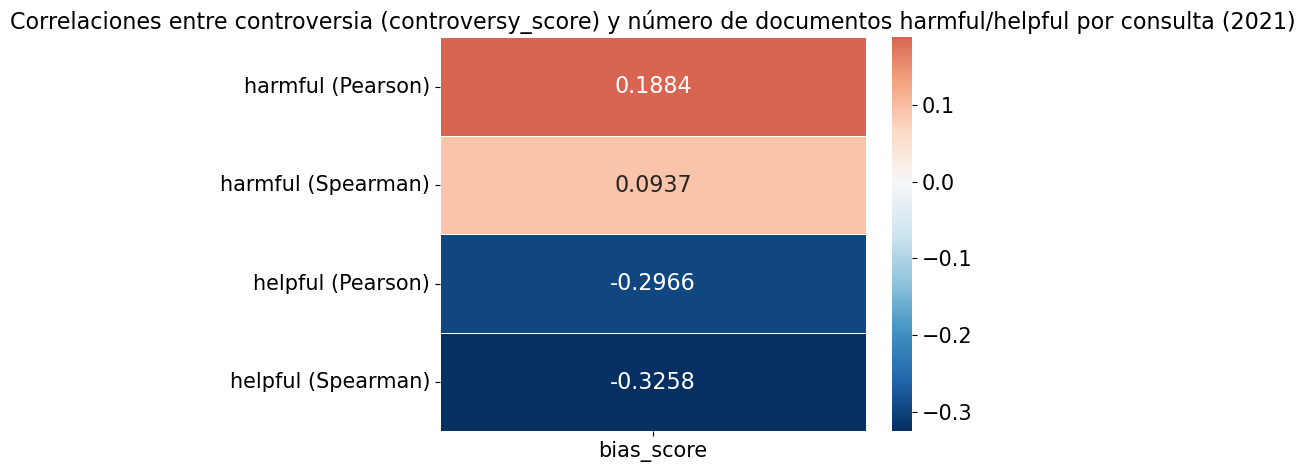

In [57]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    "bias_score": {
        "harmful (Pearson)": pearsonr(qrels_2021_prompt2["controversy_score"], qrels_2021_prompt2["harmful"])[0],
        "harmful (Spearman)": spearmanr(qrels_2021_prompt2["controversy_score"], qrels_2021_prompt2["harmful"])[0],
        "helpful (Pearson)": pearsonr(qrels_2021_prompt2["controversy_score"], qrels_2021_prompt2["helpful"])[0],
        "helpful (Spearman)": spearmanr(qrels_2021_prompt2["controversy_score"], qrels_2021_prompt2["helpful"])[0],
    }
}
correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre controversia (controversy_score) y número de documentos harmful/helpful por consulta (2021)")
plt.tight_layout()
plt.show()

### 2022

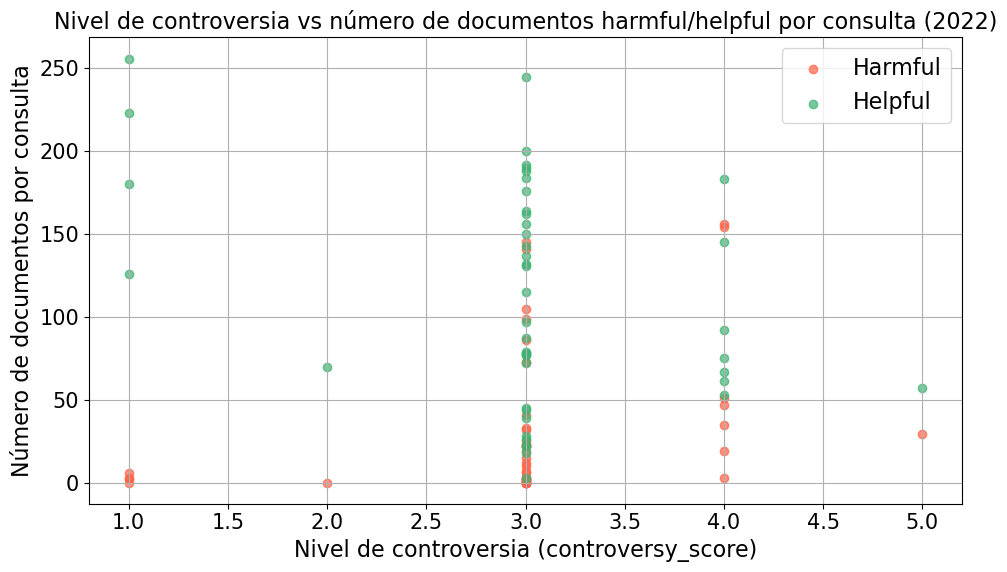

In [59]:
plt.figure(figsize=(10, 6))

# Puntos individuales por consulta
plt.scatter(qrels_2022_prompt2["controversy_score"], qrels_2022_prompt2["harmful"], color="tomato", alpha=0.7, label="Harmful")
plt.scatter(qrels_2022_prompt2["controversy_score"], qrels_2022_prompt2["helpful"], color="mediumseagreen", alpha=0.7, label="Helpful")

plt.title("Nivel de controversia vs número de documentos harmful/helpful por consulta (2022)")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos por consulta")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

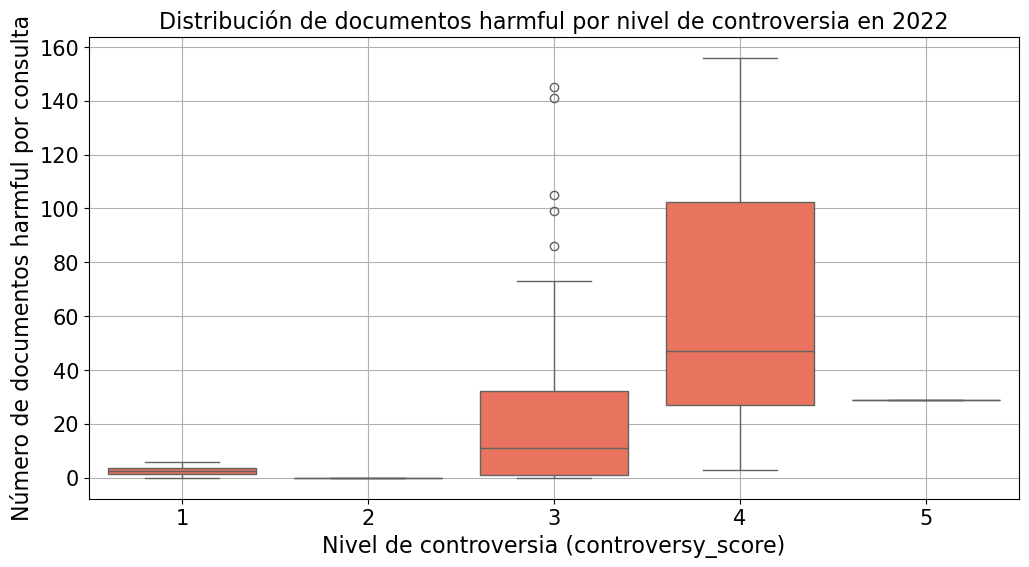

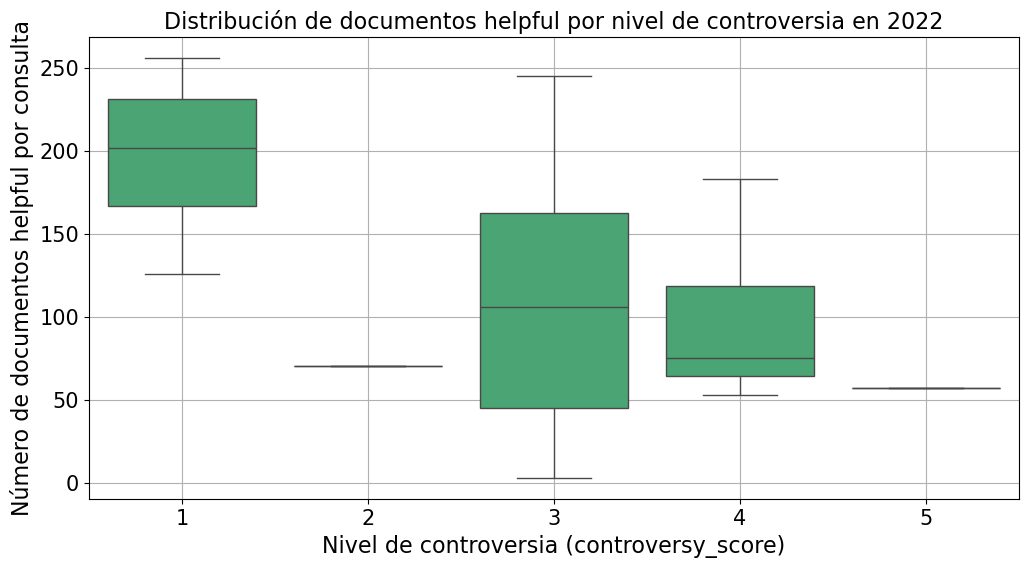

In [91]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=qrels_2022_prompt2, x="controversy_score", y="harmful", color="tomato")
plt.title("Distribución de documentos harmful por nivel de controversia en 2022")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos harmful por consulta")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=qrels_2022_prompt2, x="controversy_score", y="helpful", color="mediumseagreen")
plt.title("Distribución de documentos helpful por nivel de controversia en 2022")
plt.xlabel("Nivel de controversia (controversy_score)")
plt.ylabel("Número de documentos helpful por consulta")
plt.grid(True)
plt.show()

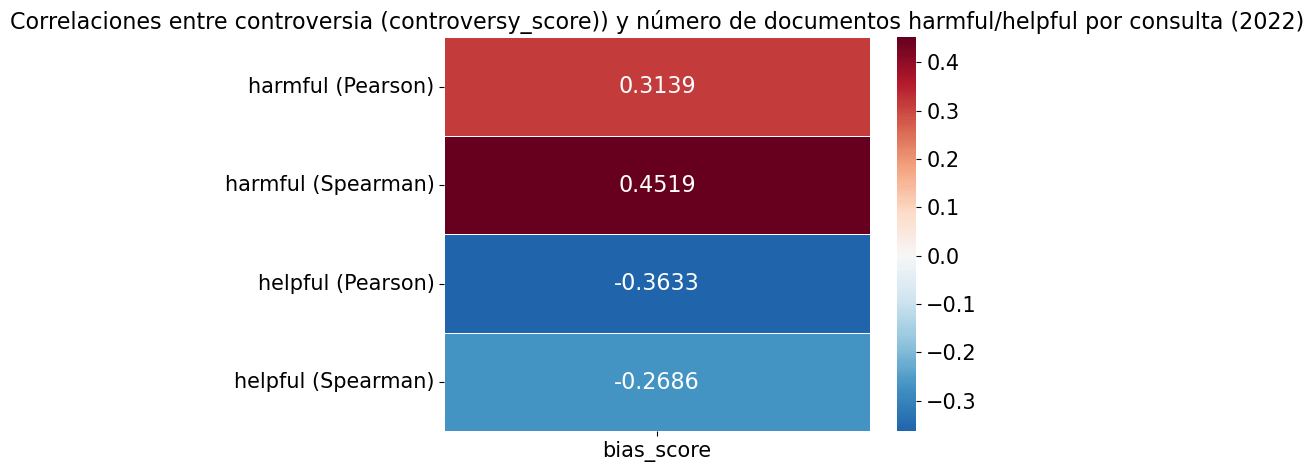

In [62]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    "bias_score": {
        "harmful (Pearson)": pearsonr(qrels_2022_prompt2["controversy_score"], qrels_2022_prompt2["harmful"])[0],
        "harmful (Spearman)": spearmanr(qrels_2022_prompt2["controversy_score"], qrels_2022_prompt2["harmful"])[0],
        "helpful (Pearson)": pearsonr(qrels_2022_prompt2["controversy_score"], qrels_2022_prompt2["helpful"])[0],
        "helpful (Spearman)": spearmanr(qrels_2022_prompt2["controversy_score"], qrels_2022_prompt2["helpful"])[0],
    }
}
correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre controversia (controversy_score)) y número de documentos harmful/helpful por consulta (2022)")
plt.tight_layout()
plt.show()

## Prompt 3

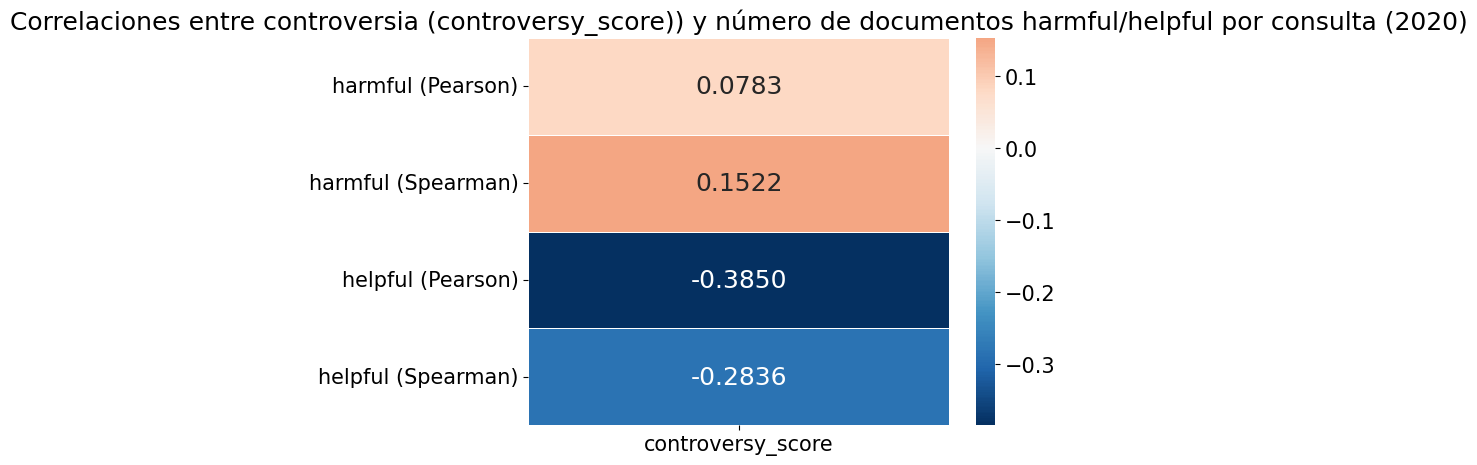

In [95]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    "controversy_score": {
        "harmful (Pearson)": pearsonr(qrels_2020_prompt3["controversy_score"], qrels_2020_prompt3["harmful"])[0],
        "harmful (Spearman)": spearmanr(qrels_2020_prompt3["controversy_score"], qrels_2020_prompt3["harmful"])[0],
        "helpful (Pearson)": pearsonr(qrels_2020_prompt3["controversy_score"], qrels_2020_prompt3["helpful"])[0],
        "helpful (Spearman)": spearmanr(qrels_2020_prompt3["controversy_score"], qrels_2020_prompt3["helpful"])[0],
    }
}
correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre controversia (controversy_score)) y número de documentos harmful/helpful por consulta (2020)")
plt.tight_layout()
plt.show()

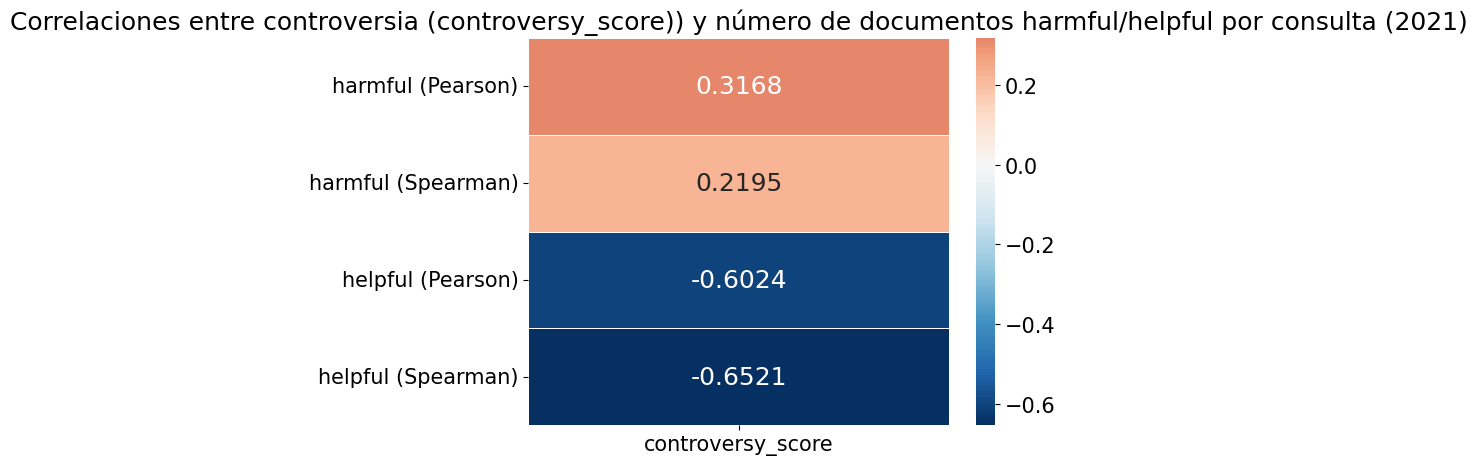

In [96]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    "controversy_score": {
        "harmful (Pearson)": pearsonr(qrels_2021_prompt3["controversy_score"], qrels_2021_prompt3["harmful"])[0],
        "harmful (Spearman)": spearmanr(qrels_2021_prompt3["controversy_score"], qrels_2021_prompt3["harmful"])[0],
        "helpful (Pearson)": pearsonr(qrels_2021_prompt3["controversy_score"], qrels_2021_prompt3["helpful"])[0],
        "helpful (Spearman)": spearmanr(qrels_2021_prompt3["controversy_score"], qrels_2021_prompt3["helpful"])[0],
    }
}
correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre controversia (controversy_score)) y número de documentos harmful/helpful por consulta (2021)")
plt.tight_layout()
plt.show()

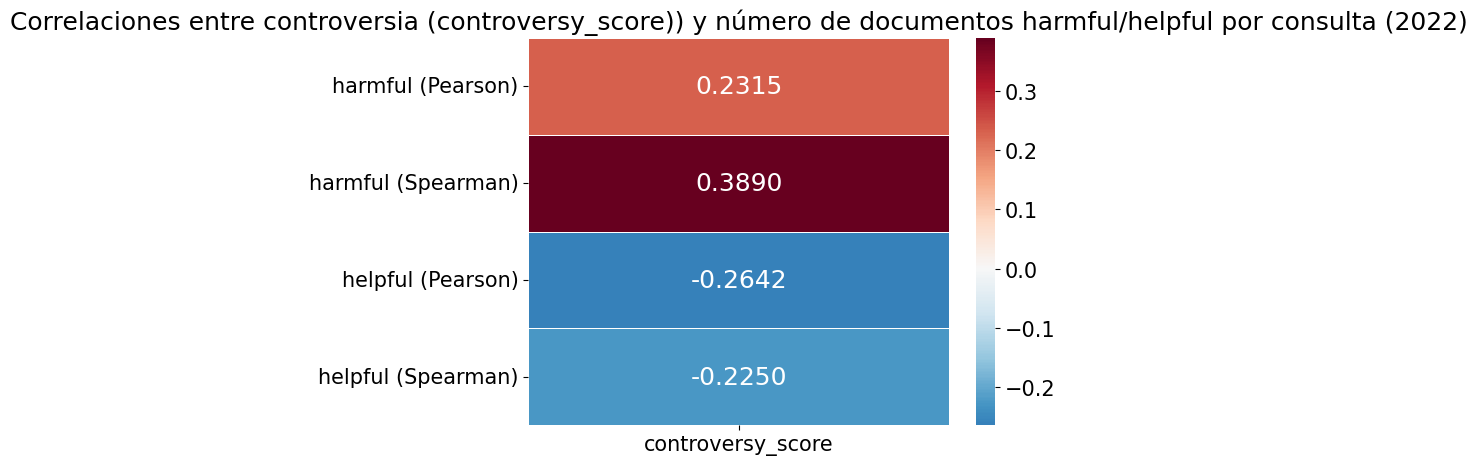

In [97]:
# Crear un DataFrame con las correlaciones
correlation_data = {
    "controversy_score": {
        "harmful (Pearson)": pearsonr(qrels_2022_prompt3["controversy_score"], qrels_2022_prompt3["harmful"])[0],
        "harmful (Spearman)": spearmanr(qrels_2022_prompt3["controversy_score"], qrels_2022_prompt3["harmful"])[0],
        "helpful (Pearson)": pearsonr(qrels_2022_prompt3["controversy_score"], qrels_2022_prompt3["helpful"])[0],
        "helpful (Spearman)": spearmanr(qrels_2022_prompt3["controversy_score"], qrels_2022_prompt3["helpful"])[0],
    }
}
correlation_df = pd.DataFrame(correlation_data)

# Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f")
plt.title("Correlaciones entre controversia (controversy_score)) y número de documentos harmful/helpful por consulta (2022)")
plt.tight_layout()
plt.show()

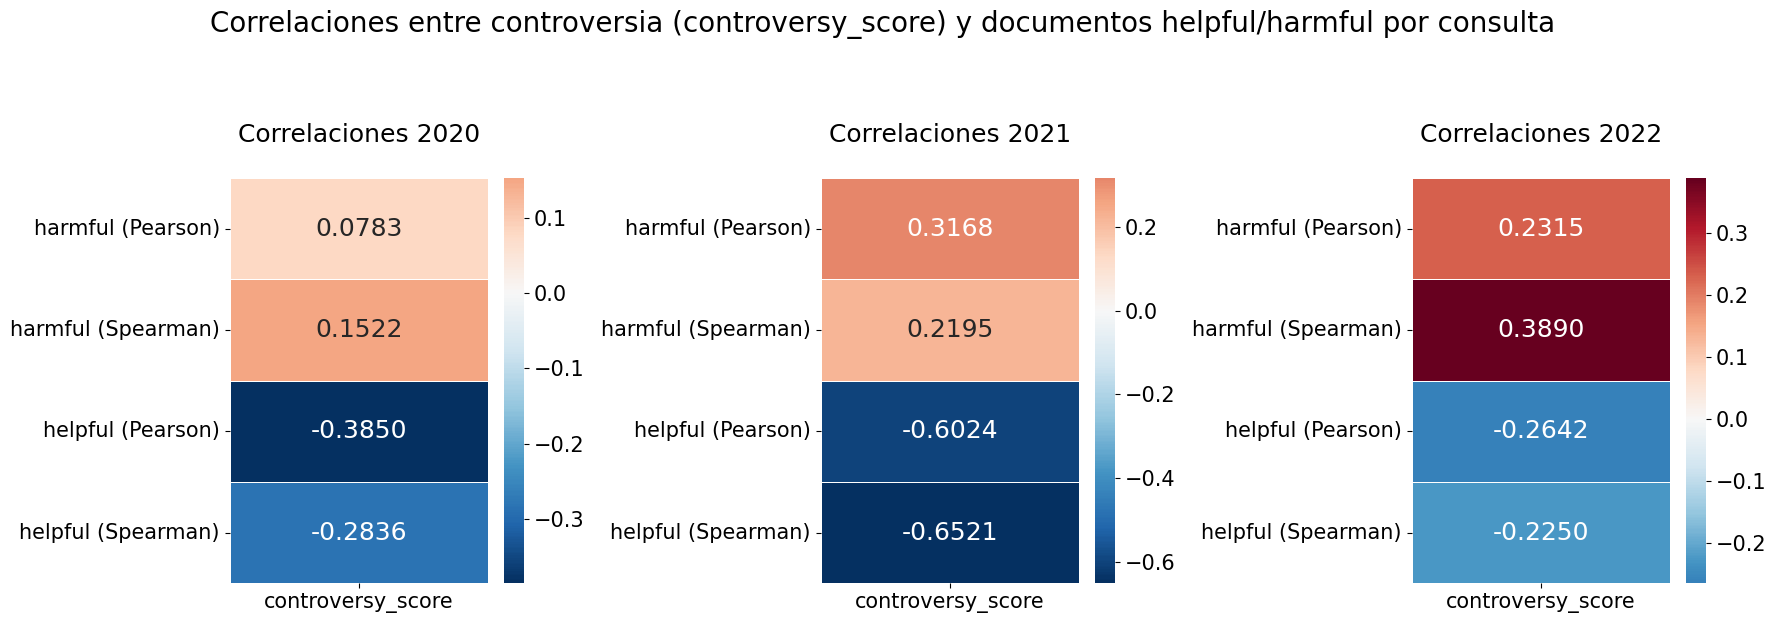

In [98]:
# Función para generar el dataframe de correlaciones
def get_correlation_df(df):
    return pd.DataFrame({
        "controversy_score": {
            "harmful (Pearson)": pearsonr(df["controversy_score"], df["harmful"])[0],
            "harmful (Spearman)": spearmanr(df["controversy_score"], df["harmful"])[0],
            "helpful (Pearson)": pearsonr(df["controversy_score"], df["helpful"])[0],
            "helpful (Spearman)": spearmanr(df["controversy_score"], df["helpful"])[0],
        }
    })

# Crear los dataframes de correlación
corr_2020 = get_correlation_df(qrels_2020_prompt3)
corr_2021 = get_correlation_df(qrels_2021_prompt3)
corr_2022 = get_correlation_df(qrels_2022_prompt3)

# Plot conjunto
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(corr_2020, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f", ax=axes[0])
axes[0].set_title("Correlaciones 2020\n")

sns.heatmap(corr_2021, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f", ax=axes[1])
axes[1].set_title("Correlaciones 2021\n")

sns.heatmap(corr_2022, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, fmt=".4f", ax=axes[2])
axes[2].set_title("Correlaciones 2022\n")

fig.suptitle("Correlaciones entre controversia (controversy_score) y documentos helpful/harmful por consulta", y=1.05)

plt.tight_layout()
plt.show()

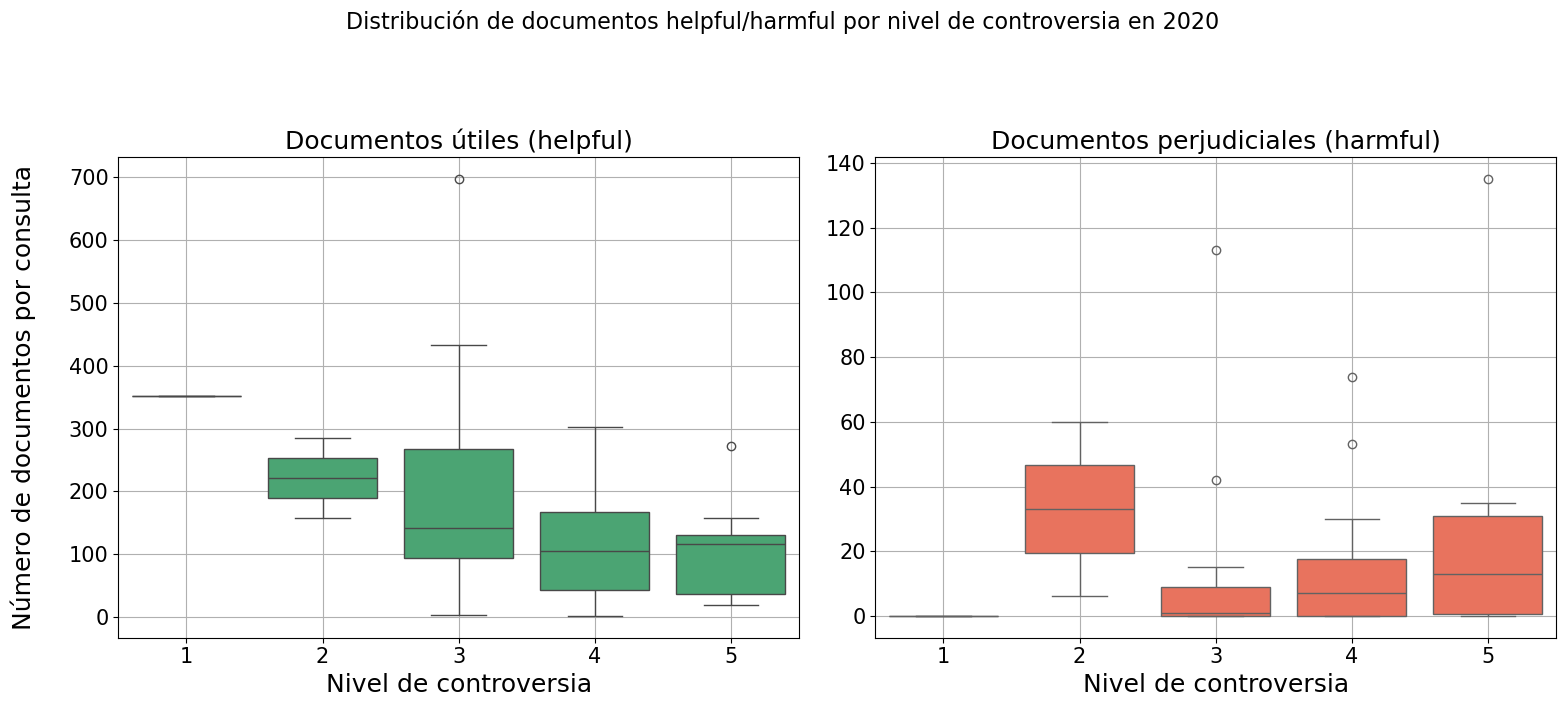

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True)

# Título principal
fig.suptitle(
    "Distribución de documentos helpful/harmful por nivel de controversia en 2020\n", 
    fontsize=16, 
    y=1.02
)

# Gráfico helpful (izquierda)
sns.boxplot(
    data=qrels_2020_prompt3, 
    x="controversy_score", 
    y="helpful", 
    color="mediumseagreen", 
    ax=axes[0]
)
axes[0].set_title("Documentos útiles (helpful)")
axes[0].set_xlabel("Nivel de controversia")
axes[0].set_ylabel("Número de documentos por consulta\n")
axes[0].grid(True)

# Gráfico harmful (derecha)
sns.boxplot(
    data=qrels_2020_prompt3, 
    x="controversy_score", 
    y="harmful", 
    color="tomato", 
    ax=axes[1]
)
axes[1].set_title("Documentos perjudiciales (harmful)")
axes[1].set_xlabel("Nivel de controversia")
axes[1].set_ylabel("")
axes[1].grid(True)

plt.tight_layout()
plt.show()

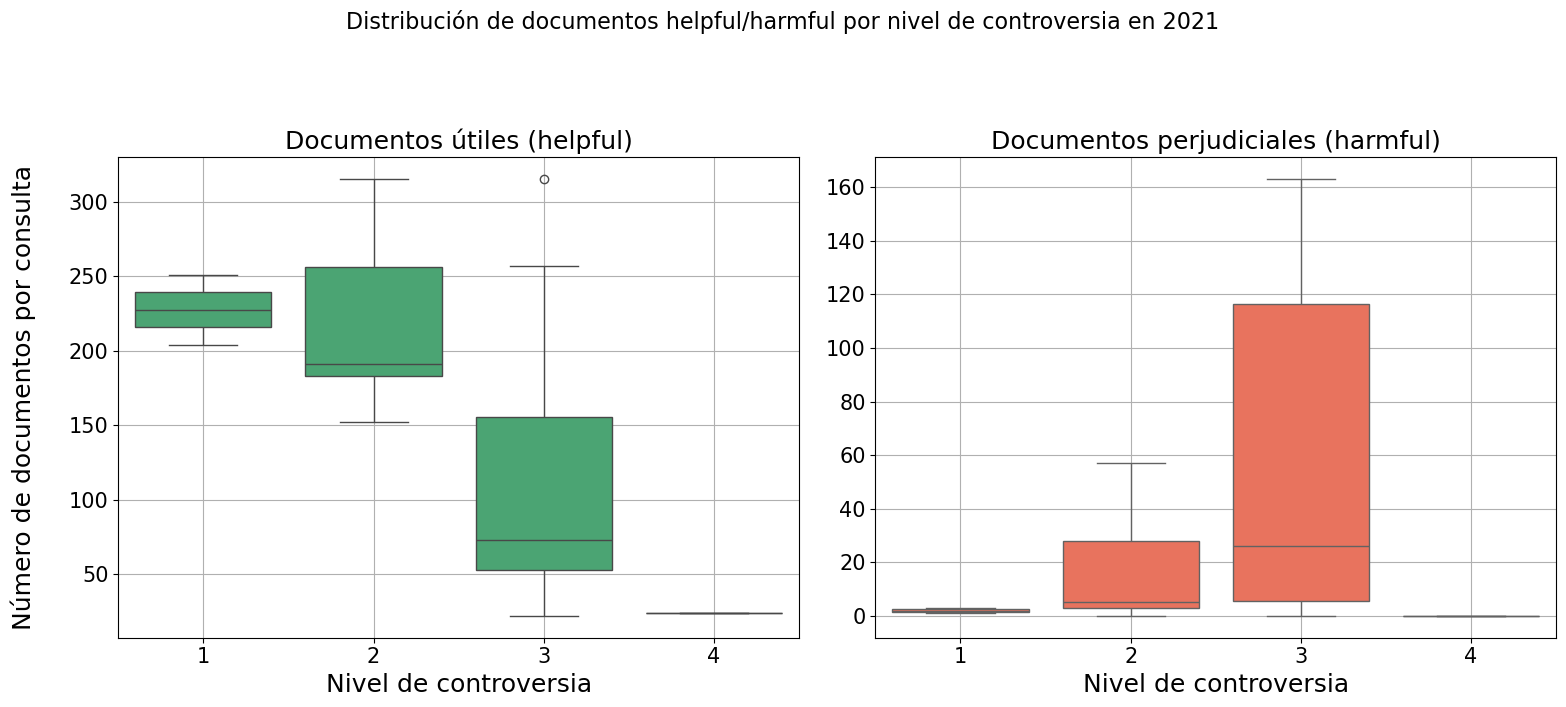

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True)

# Título principal
fig.suptitle(
    "Distribución de documentos helpful/harmful por nivel de controversia en 2021\n", 
    fontsize=16, 
    y=1.02
)

# Gráfico helpful (izquierda)
sns.boxplot(
    data=qrels_2021_prompt3, 
    x="controversy_score", 
    y="helpful", 
    color="mediumseagreen", 
    ax=axes[0]
)
axes[0].set_title("Documentos útiles (helpful)")
axes[0].set_xlabel("Nivel de controversia")
axes[0].set_ylabel("Número de documentos por consulta\n")
axes[0].grid(True)

# Gráfico harmful (derecha)
sns.boxplot(
    data=qrels_2021_prompt3, 
    x="controversy_score", 
    y="harmful", 
    color="tomato", 
    ax=axes[1]
)
axes[1].set_title("Documentos perjudiciales (harmful)")
axes[1].set_xlabel("Nivel de controversia")
axes[1].set_ylabel("")
axes[1].grid(True)

plt.tight_layout()
plt.show()

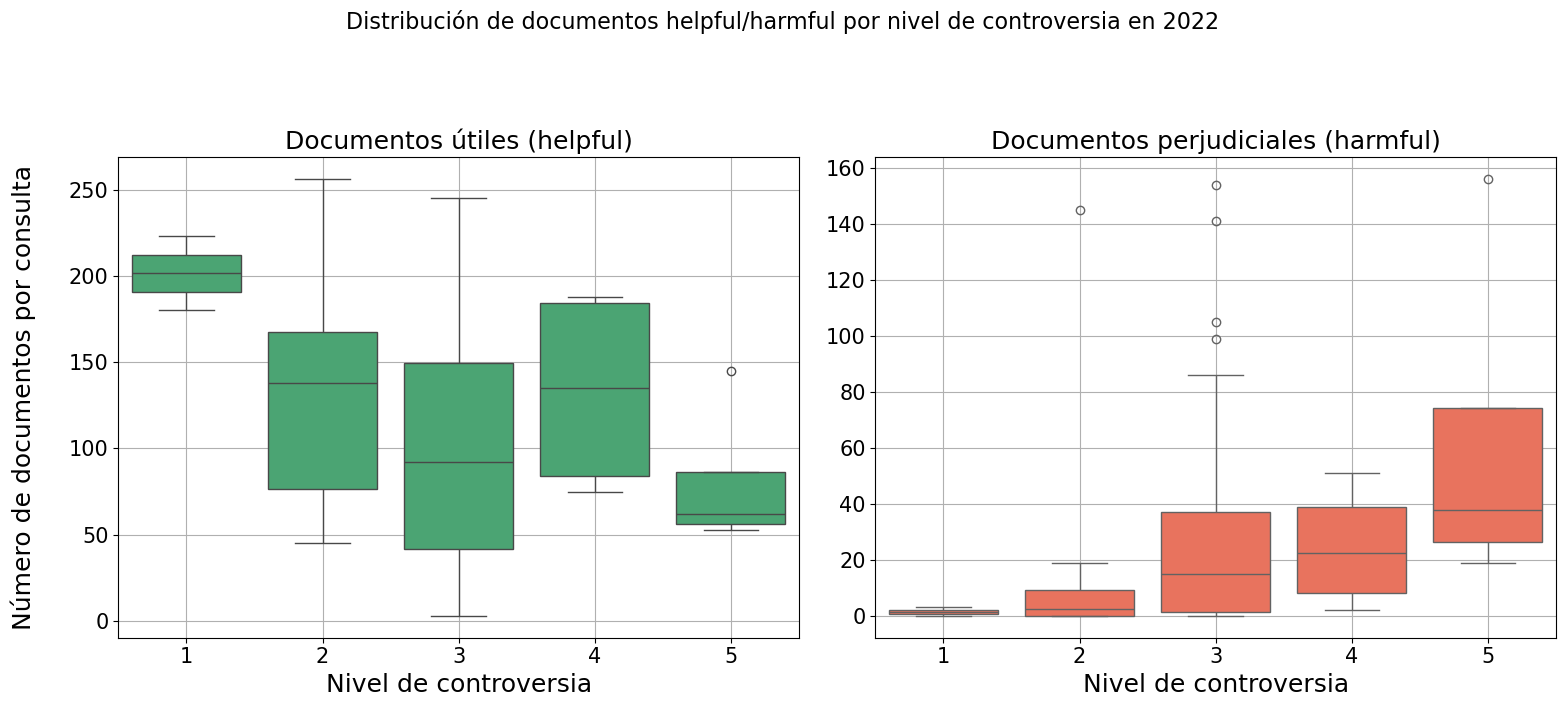

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True)

# Título principal
fig.suptitle(
    "Distribución de documentos helpful/harmful por nivel de controversia en 2022\n", 
    fontsize=16, 
    y=1.02
)

# Gráfico helpful (izquierda)
sns.boxplot(
    data=qrels_2022_prompt3, 
    x="controversy_score", 
    y="helpful", 
    color="mediumseagreen", 
    ax=axes[0]
)
axes[0].set_title("Documentos útiles (helpful)")
axes[0].set_xlabel("Nivel de controversia")
axes[0].set_ylabel("Número de documentos por consulta\n")
axes[0].grid(True)

# Gráfico harmful (derecha)
sns.boxplot(
    data=qrels_2022_prompt3, 
    x="controversy_score", 
    y="harmful", 
    color="tomato", 
    ax=axes[1]
)
axes[1].set_title("Documentos perjudiciales (harmful)")
axes[1].set_xlabel("Nivel de controversia")
axes[1].set_ylabel("")
axes[1].grid(True)

plt.tight_layout()
plt.show()